<center><h1>Report of Project 3: "Implementation and evaluation of Otsu Thresholding"</h1></center>

*Elizaveta Chernova, Veronika Schuler, Laura Wächter, Hannah Winter*

<h2>Abstract</h2>
<br>
<div style="text-align: justify">
Thresholding is a useful method that is frequently used in the context of
image segmentation.
In this project, we used Otsu's thresholding algorithm in order to find the optimal threshold value,
that optimizes the image segmentation.
This algorithm was applied to a number of images from different datasets (N2DH-GOWT1, N2DL-HeLa, NIH3T3).
To improve the results, several preprocessing methods (mainly filters) were used.
The final segmentations were compared to reference pictures and evaluated with several methods (Dice Score, MSD, Hausdorff distance).
The different datasets are characterized by different features, like reflections or low contrast.
For this reason, it is likely that different preprocessing methods will lead to the optimal result.
Our overall analysis confirms this hypothesis.
</div>

<h2>Table of contents</h2>

...

<h2>Introduction</h2>
<br>
<div style="text-align: justify">
In computer vision, <i>image segmentation</i> is used for a variety of purposes. In general, image segmentation
describes the process of dividing a digital image into multiple segments
to simplify the image. These simplified images can be used for further analysis. In the field of medicine or biology,
image segmentation is often used to locate tumors and other pathologies or to measure tissue volume.
Segmentations of images displaying cell nuclei are often used as an input for
algorithms that measure the number or size of the cell nuclei. If time-lapse images are used,
it is also possible to track the cell movement.
<br>
<br>
    <i>Thresholding</i> is a simple method of image segmentation. Based on a single intensity value, the image is divided into two segments:
 Pixels with higher intensities than the threshold value are distinguished from the pixels with intensities lower than the threshold.
 In order to find the threshold value, that results in the best possible image segmentation we used "Otsu's Thredholding" algorithm.
<br>
<br>
In the course of the project, three different datasets have been used,
 each of which presented themselves with different challenges:
 Low contrast, noise and reflections made it difficult to distinguish the cells from the background.
 In order to achieve good results despite these difficulties, different preprocessing methods were applied to the images prior to the image segmentation.
 Due to the differences between the datasets we hypothesized that the different preprocessing methods will result in the optimal segmentation for every dataset.
<br>
<br>
The accuracy of the obtained segmented images was evaluated by using the Dice score as well as the Median Surface Distance (MSD)
and the Hausdorff distance. These metrics compare the obtained segmentated image to a reference, a manually segmented ground truth image.
Beyond that, a cell counting algorithm was implemented, which is one of the possible ways to use the segmented images.



<h3>Description of the datasets</h3>

<h5>N2DH-GOWT1 cells</h5>
The dataset N2DH-GOWT1 of the cell tracking challenge (Bártová et al., 2011) contains images of GFP-GOWT1 mouse
embryonic stem cells that have been derived with time-lapse confocal microscopy with a Leica TCS SP5 microscope.
The varying brightness of the cells makes it hard to distinguish all the cells from the background. 
The noise in the images and low contrast also represent challenges for the segmentation algorithm.

<h5>N2HL-HeLa cells</h5>
The dataset N2DL-HeLa of the cell tracking challenge (Neumann et al., 2010) contains images of human epithelial cells
of cervical cancer. Those images have been derived with an Olympus IX81 microscope used for live imaging of
fluorescently labelled chromosomes. The challenge in these images is the variety of brightness of the cells.

<h5>NIH3T3 cells</h5>
The dataset NIH3T3 (Coelho et al., 2009) contains images of several mouse embryonic fibroblast cells. These images
have also been derived with fluorescence microscopy images. The difficulty in segmenting these images
lies mainly in the bright light spots, probably reflections resulting from the used microscoping approach. Because of these spots, the algorithm chooses a threshold that lies too high, which results in a less sucessful segmentation.
</div>



In [79]:
# Import of the Modules
from nuclei_segmentation import metrics, complete_analysis, visualisation, evaluation, otsu, preprocessing
from skimage import io
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
import numpy as np
import pathlib as pl
import json
import pandas as pd
import warnings
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
warnings.filterwarnings('ignore')

<div style="text-align: justify">
    
<h2>Methods</h2>
<br>
The following preprocessing methods were tested with intent to improve the results of  Otsu's thresholding algorithm by reducing noise and other disruptive factors in the input images.


<h3>Preprocessing</h3>
<h4>Gaussian filter</h4>
The intent of the Gaussian filter is to blur the images and therefore to reduce noise. In the optimal case, this filter helps to reduce the reflections in the images, that might disturb the thresholding algorithm. The Gaussian kernel, that is used to compute the weighted average of the pixels, has the shape of the 2D zero-mean Gaussian function $G_\sigma$ with standard deviation $\sigma$. The higher $\sigma$ is set, the stronger is the blurring effect in the processed image.

\begin{align*}
G_\sigma(x,y) = \frac{1}{\sigma^2 2π}  e^\frac {-(x^2 + y^2)}{2\sigma^2} \\
\end{align*}

<h4>Median filter</h4>
The Median filter is a non linear filter, that is often used to reduce noise in images.
The gray-values of all pixels in a pixel neighborood of a defined size are ranked by size. The intensity value of the central pixel is then substituted through the median of its neighbourhood.
This filter is particularly useful to reduce salt and pepper noise in images.
Compared to the Gaussian filter, a useful feature of the Median filter is that edges are preserved while the overall noise is reduced. 

<h4>Histogram stretching</h4>
Histogram stretching is a technique that aims to enhance the contrast of an image and might therefore help to optimize the segmentation results. The range of intensity values is 'stretched' to a desired minimal an maximal intensity value.
The first step is to take all intensity values in the image and to select the minimal intesity value $c$ and the maximal intensity value $d$ of the input image as the $2nd$ and $98th$ percent quantiles. The lower and upper pixel intensity limits $a$ and $b$ to which the image is stretched are often times the minimum and the maximum pixel values of the respective image type. Hence, for 8 bit gray-level images $a$ is set to $0$ whereas $b$ is set to $255$. These values must be adjusted accordingly for other image types. The pixel intensity of the output image $P_{out}$ is calculated from the pixel intensity $P_{in}$ of the input image based on the following linear function:

\begin{align*}
P_{out} = (P_{in} - c) \frac{(b-a)}{(d-c)} + a
\end{align*}
<br>

<h3>Thresholding</h3>
<h4>Otsu's Thresholding</h4>
In order to adequately seperate objects from the backround it is important to select an optimal threshold value.
In the optimal case, the image histogram shows a bimodal distribution.
 In this scenario, the threshold could simply be selected at the bottom of the valley between the two intensity peaks representing foreground and background.
 However, in most cases it is not obvious where the optimal threshold value lies. In this case, Otsu's thresholding method allows us to compute the best threshold value automatically.
  The algorithm computes the inbetween class variance $\sigma_B$ for all possible threshold values. Every threshold value seperates all pixels in the image in two classes:
  Pixels with a lower intensity and pixels with a higher intensity than the threshold value.
  The between-class variance $\sigma_B$ is calculated from the probability of class occurrence $\omega$, the mean intensity values $\mu$ of both pixel classes as well as the total intensity value variance $\mu_T$.
   The intensity level that maximizes the inbetween-class variance is selected as the optimal threshold value.

\begin{align*}
   σ_B^2 = ω_1(µ_1 - µ_T)^2 + ω_2(µ_2 - µ_T)^2
\end{align*}

In order to recieve a segmented, binary image, the pixel intensity $g(x,y)$ has to be changed accordingly. Pixels with a lower or equal intensity value than the optimal threshold $k$ are set to $0$. Analogous to this, all pixels with a higher intensity value than the threshold are set to $1$.

\begin{align*}
     g_{segmentation} (x,y)=\left\{\begin{array}{ll}0 & if & g(x,y) \leq k  \\
     1 & if & g(x,y) > k\end{array}\right.
\end{align*}

<h4>Two-level Otsu's thresholding</h4>
Otsu's thresholding method can easily be extended to multithresholding problems. We choose it to try to reduce the bright reflection spots in the NIH3T3 dataset, that might otherwise be recognized as cell nuclei by the algorithm. The main idea is to set two threshold values: The higher threshold value seperates the reflections from the remaining image whereas the lower threshold value seperates the cell nuclei from the background. The computation of two threshold values results in three different pixel classes. Analogous to the one-level algorithm, the optimal threshold values are computed by minimizing the inbetween-class variance between the classes:

\begin{align*}
   σ_B^2 = ω_1(µ_1 - µ_T)^2 + ω_2(µ_2 - µ_T)^2 + ω_3(µ_3 - µ_T)^2
\end{align*}

In our case the next step was setting all pixels having a higher intensity than the upper threshold value (ideally the reflections in the image) to $0$. All pixels having a lower or equal intensity than the lower threshold value were also set to $0$. The remaining pixels were set to $1$.

<h3>Evaluation</h3>
In order to evaluate the result of the image segmentation based on Otsu's thresholding algorithm, the segmented images were compared with reference images. For every picture in the dataset there is a binary 'Ground truth' image, that displays an accurate segmentation of the respective image. The correspondence of our final segmentation and the 'Ground truth' image can be evaluated by using various metrics.

<h4>Dice Score</h4>
The Dice score (DSC) is often used in order to assess the performance of image segmentation algorithms. The Dice score is a measure of similarity between the segmented image and the 'Ground truth'. Its value corresponds to the size of overlap between all pixels with intensity $1$ in the segmented picture $S$ and in the 'Ground truth' image $G$.

\begin{align*}
    DSC = \frac{2\cdot TP + FP}{2\cdot TP + FP + FN} \\
\end{align*}

The Dice score lies within the interval $[0,1]$. In the event of a complete match between the segmented image and the 'Ground truth' image, the obtained Dice score is $1$. In the opposite case, the obtained Dice Score is $0$. In general, higher Dice scores indicate a more precise image segmentation.

<h4>Surface Distances</h4>
Surface distances are another way to evaluate an image segmentation method by comparing the segmented image with the 'Ground truth' image. The distance $D$ between a point $s$ in the set of pixels $S$ (all pixels with intensity $1$ in the segmented image) to the set of pixels $G$ (all pixels with intensity $1$ in the 'Ground truth' image) corresponds to the minimal euclidean distance between $s$ and all pixels $g$ in $G$:

\begin{align*}
    D(s, G) = min \{d(s - g)| g \in G\}
\end{align*}

This distance is computed for every pixel in both sets $S$ and $G$, whereby the total distances $D(S,G)$ and $D(G,S)$ (two distance vectors) between the pixel sets are obtained. The Mean surface distance (MSD), as the name implies, is the average surface distance between the two pixel sets by adding up all distances and dividing by the total number of pixels $n_S$ and $n_G$ in both pixel sets. For smaller MSD values the segmentation is more accurate.

\begin{align*}
    MSD = \frac{1}{n_S + n_G}   \left(\sum_{p=1}^{n_S} D(s,G) + \sum_{g=1}^{n_G}  D(g,S)\right)
\end{align*}

By contrast, the Hausdorff distance (HD) named after the German mathematican Felix Hausdorff is the maximal surface distance between the two pixel sets. For smaller HD values, the segmentation is more accurate.

\begin{align*}
    HD = max\{D(S,G),D(G,S)\}
\end{align*}

In general, the Hausdorff distance is very sensitive to outliers and therefore not recommended if outliers are likely.

<h3>Cell counting</h3>
The basic idea of our cell counting algorithm is to identify all pixels that form the outline of the segmented cells.
 These ‘border pixels’ are located by identifying intensity changes from zero to one in the segmented image.
 By grouping adjacent border pixels, all pixels belonging to the same shape are combined into groups.
 The count of the obtained groups matches the count of cells in the image. The picture below visualizes the located 'outline pixels'.
</div>

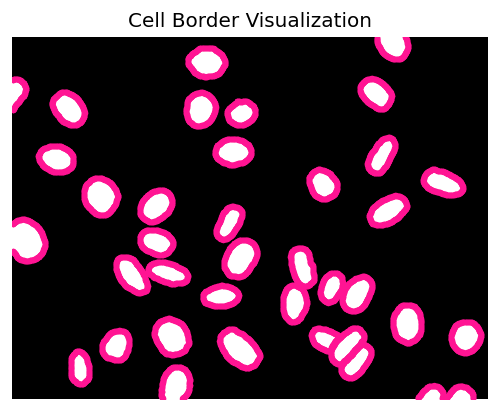

In [80]:
cell_counting_example = io.imread(str(pl.Path('./Data/NIH3T3/gt/42.png')))
border_pixels = metrics.find_border(cell_counting_example)
visualisation.border_image(cell_counting_example, border_pixels);

<h2>Outcomes</h2>
<br>
<div style="text-align: justify">
Five different preprocessing methods were applied to the images: Histogram stretching, the gaussian and median filter individually as well as two combinations: The gaussian filter and the median filter were each combined with histogram stretching. The results are precalculated and saved in .json files but if desired, they can be recalculated in a few hours.
</div>

In [75]:
# Set to True if one level recalculations are desired (requires a few hours...)
data_one_level = complete_analysis.recalculation_desired(recalculate_data=False, path_to_data="Results/values.json")
# Set to True if two level recalculations are desired (requires a few hours...)
data_two_level = complete_analysis.recalculation_desired(recalculate_data=False, path_to_data="Results/two_lvl.json")

The optimal preprocessing method for each dataset are determined based on the mean Dice Scores as well as the mean surface distances of every dataset.
In the following, the results for each dataset are discussed individually. Thereby, also the distribution of the evaluation measure values is taken into account.

<h3>1. N2DH-GOWT1 Dataset</h3>

<h4>1.1. N2DH-GOWT1 Results </h4>
Based on the mean values of the evaluation measures, the following optimal preprocessing methods were obtained:

In [76]:
complete_analysis.result_evaluation("Results/values.json", ["N2DH-GOWT1"])

N2DH-GOWT1 (dice) : 0.817   --->   Median filter and histogram stretching
N2DH-GOWT1 (msd) : 3.389   --->   Histogram stretching
N2DH-GOWT1 (hd) : 221.375   --->   Median filter and histogram stretching


The plot below, visualizes the distribution of the Dice scores for every dataset. A general trend is that preprocessing methods including histogram stretching result in a better segmentation result than other preprocessing methods.

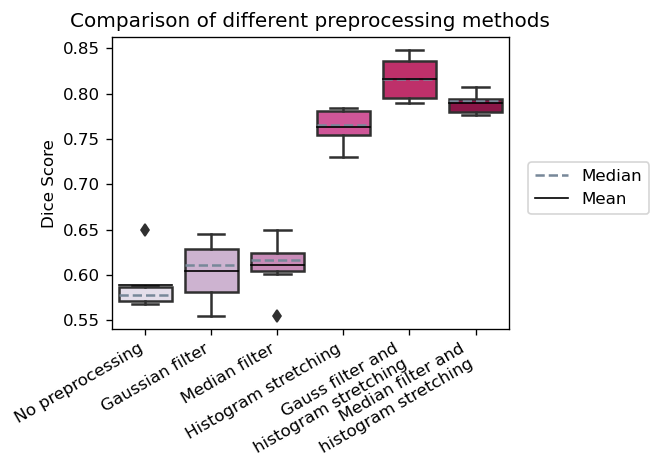

In [81]:
visualisation.comparison_boxplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "N2DH-GOWT1"))

The distribution of the Mean square distances for all possible preprocessing methods also rate the combinations containing histogram stretching the best. However, the difference is not as obvios as in the Dice score distribution. Further, images without preprocessing are rated very high in contrast to the evaluation based on the Dice score.

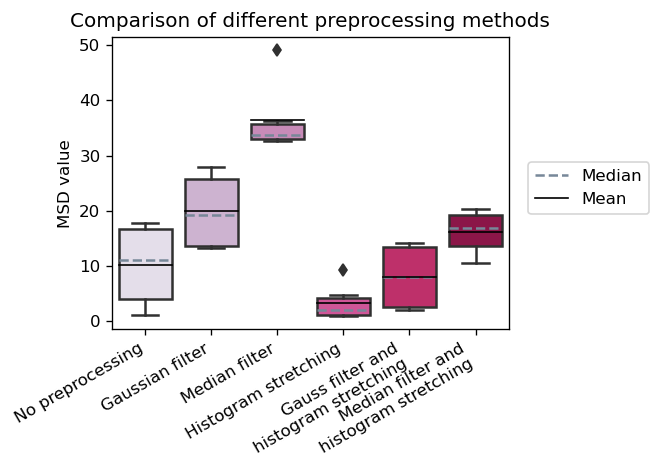

In [82]:
visualisation.comparison_boxplot(complete_analysis.get_one_lvl_msd(data_one_level, dataset = "N2DH-GOWT1"),
                                   y_label = 'MSD value')

<h4>1.2. N2DH-GOWT1 Discussion </h4>
All of the images in the first dataset are very low in contrast. Even with naked eye, some cells are difficult to recognize. As the main effect of filters is to blur images, they are not helpful to improve the segmentation result in this context. The following figure shows that the filters do not have a significant effect on the overall appearance of the images.

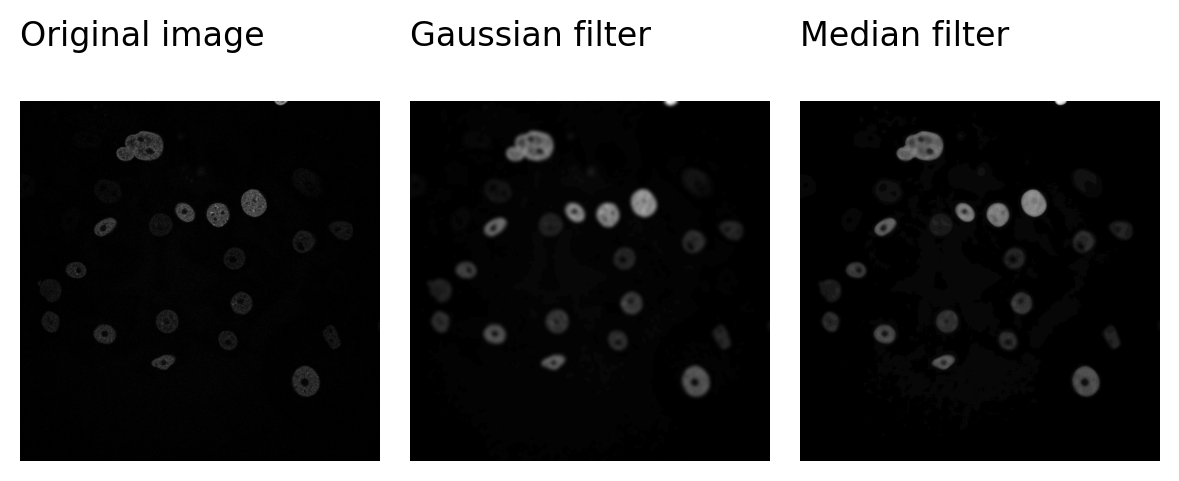

In [54]:
image = io.imread(str(pl.Path('Data/N2DH-GOWT1/img/t01.tif')))
kernel = preprocessing.gaussian_kernel(21, 5)
gaussian_image = preprocessing.convolution(image, kernel)
median_image = preprocessing.median_filter(image,15)
visualisation.three_img_plot(image,gaussian_image, median_image,"Original image","Gaussian filter", "Median filter")

The reason histogram stretching works so well regarding this dataset is that it increases contrast. This makes it easier
to set a threshold that separates the cell nuclei from the background and therefore results in a better segmentation
result. Based on the following graphs it is easy to see that the more cells are detected by the segmentation algorithm
after applying histogram stretching to the images.

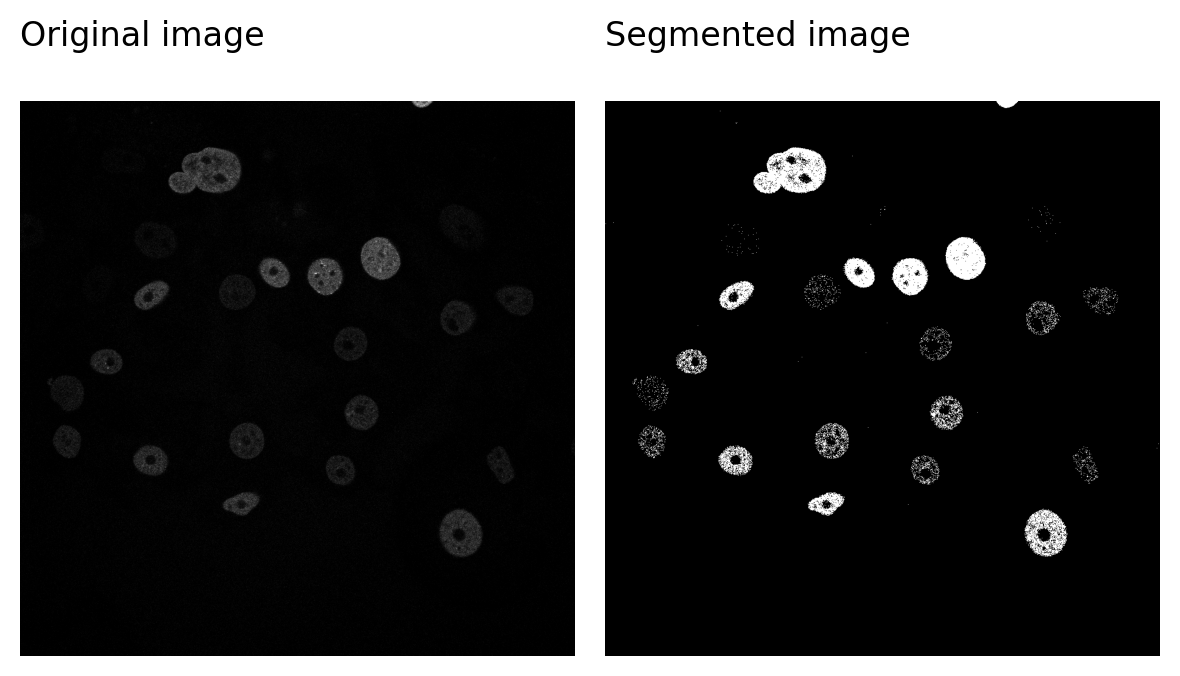

In [55]:
stretched_image = preprocessing.histogram_stretching(image, intensity_lvls = 2**16)
segmented_image = otsu.complete_segmentation(image,intensity_lvls = 2**16)
segmented_stretched_image = otsu.complete_segmentation(stretched_image,intensity_lvls = 2**16)
visualisation.two_img_plot(image,segmented_image,'Original image','Segmented image')

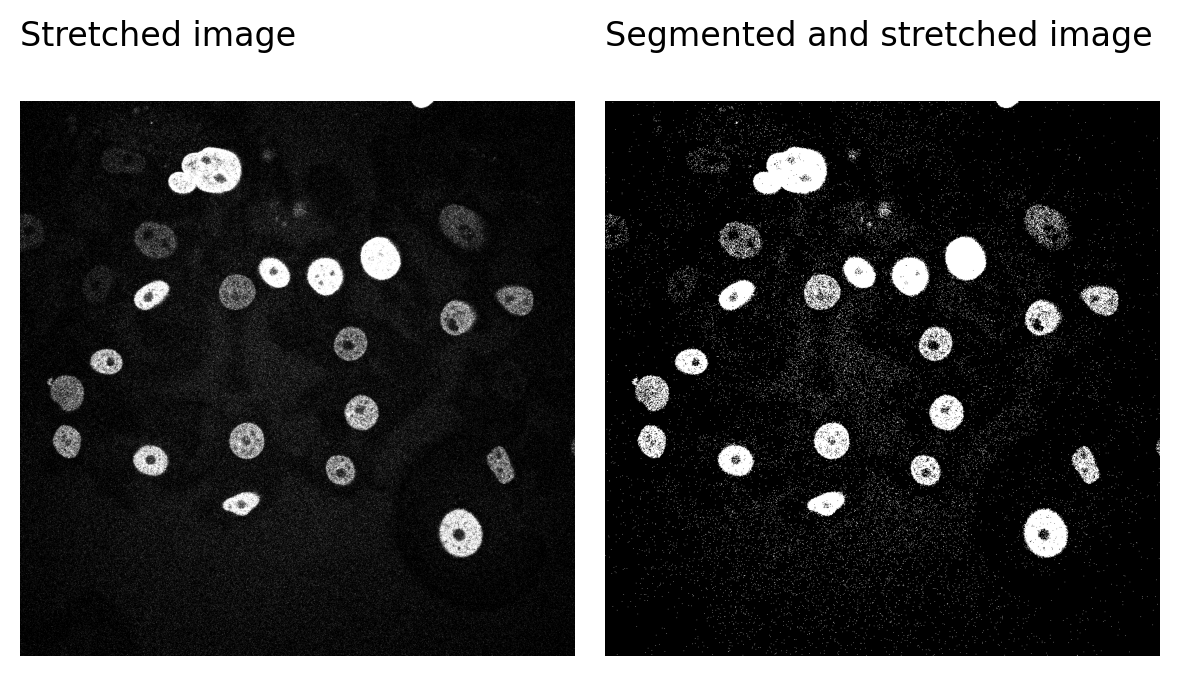

In [56]:
visualisation.two_img_plot(stretched_image,segmented_stretched_image,'Stretched image','Segmented and stretched image')

<div style="text-align: justify">
It can therefore be said that the use of filters is insignificant for this dataset. Since the only difficulty about the images in this dataset is the low contrast and otherwise there is no major noise, histogram stretching seems to be the preprocessing method that optimizes the segmentation result.
<br>
As mentioned in the results, segmentations resulting from images without preprocessing are rated higher by the MSD value than un-preprocessed pictures.  The reason for that might be, that the MSD value is simply a measurure based on the minimal pixel distances between the 'Ground truth' image and the final segmentation result. As the segmentations based on the images without preprocessing simply miss out multiple pixels belonging to cell nuclei, the MSD value is not affected as much. Hence, regarding this dataset, the Dice score is better suitable to evaluate the segmentation results than the MSD value.
    </div>

<h3>2. N2DL-HeLa Dataset</h3>

<h4>2.1. N2DL-HeLa Results </h4>
For the second dataset, the combination the Median filter and Histogram stretching was found to result in the best segmentation results:

In [57]:
complete_analysis.result_evaluation("Results/values.json", ["N2DL-HeLa"])

N2DL-HeLa (dice) : 0.76   --->   Median filter and histogram stretching
N2DL-HeLa (msd) : 5.527   --->   Median filter and histogram stretching
N2DL-HeLa (hd) : 119.439   --->   Gaussian filter


However, the overall distribution of the Dice scores for the images in the dataset shows that there is not a big difference with regard to the performance of the different preprocessing methods. With the exception of one outlier, the segmentes pictures are very accurate in total.  

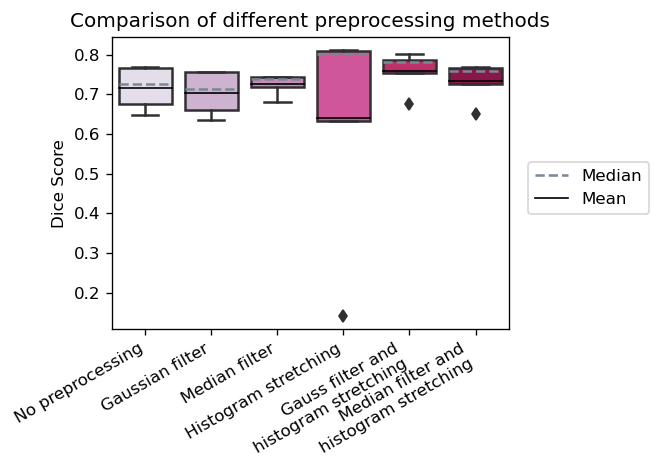

In [83]:
visualisation.comparison_boxplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "N2DL-HeLa"))

The evaluation based on the Hausdorff distance suggests that only the Gaussian filter alone results in the best image segmentation. Generally, there is a high dispersion of the Hausdorff distance values.

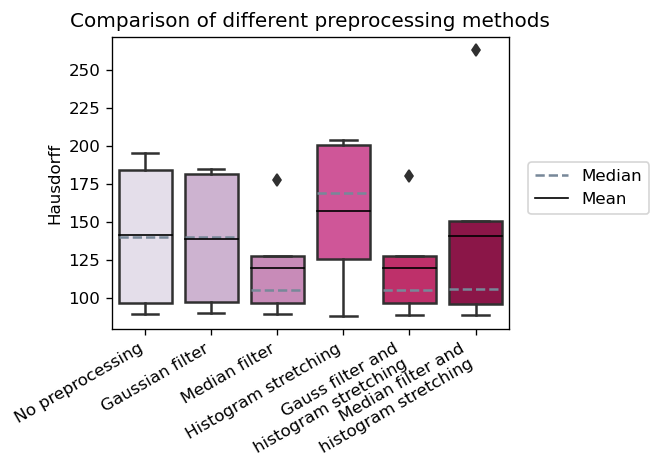

In [85]:
visualisation.comparison_boxplot(complete_analysis.get_one_lvl_hd(data_one_level, dataset = "N2DL-HeLa"), y_label="Hausdorff")

<h4> 2.2 N2DL-HeLa Discussion </h4>
The major challenge of this dataset is the strongly varying brightness of the cell nuclei in the images. Some cell nuclei are very difficult to distinguidh from the background while others are so bright that they could be reflections. The degree of this characteristic is different for each image. This characteristic explains the 'outlier' within the image segmentation results that were evaluated using the Dice Score:
<br>
In the respective image, the variance in brightness between the cell nuclei is very distinct. After applying histogram stretching, a lot of cell nuclei were lost to the background in the final segmented image.

In [60]:
image = io.imread(str(pl.Path('Data/N2DL-HeLa/img/t79.tif')))
stretched_image = preprocessing.histogram_stretching(image, intensity_lvls = 2**16)
segmented_image = otsu.complete_segmentation(stretched_image,intensity_lvls = 2**16)
ground_truth = io.imread(str(pl.Path('Data/N2DL-HeLa/gt/man_seg79.tif'))) 

Simply put, histogram stretching increases the brightness of already bright spots in the image and reduces the brightness in darker spots. If there are large differences in the brightness of the different cells, this characteristic is reinforced. Thhis makes it even more difficult to find a suitable threshold value that separates the cell nuclei from the background. Therefore, the application of histogram stretching leads to the loss of many cell nuclei in the segmented image. The overlay of the ground truth and the segmented and sttretched image visualizes that there is a very high percentage of false negative pixels

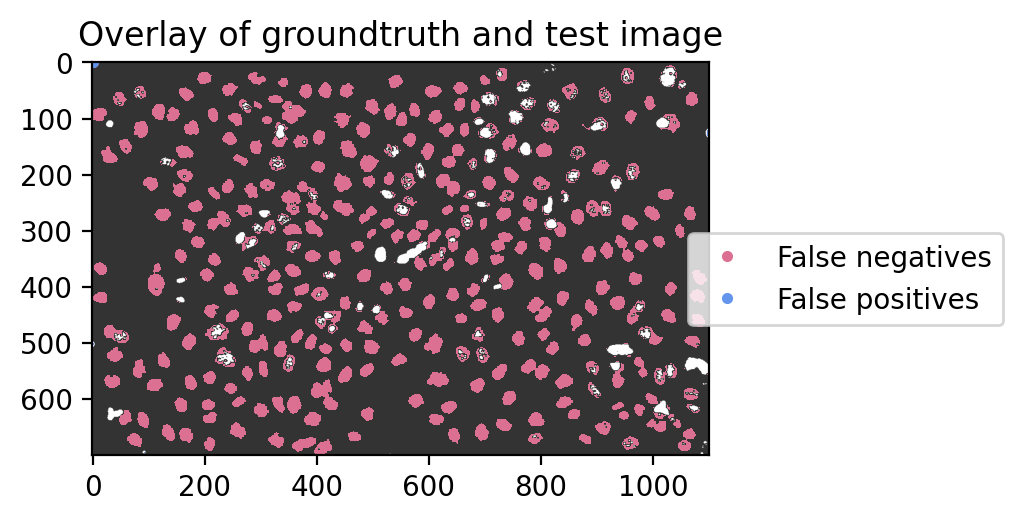

In [61]:
visualisation.overlay(segmented_image, ground_truth)

- in den restlichen Bildern allgemein sehr gut
- Grund: keine so starke variation der helligkeit zwischen cell nuclei; einfachere Unterscheidung von Zellen und Hintergrund, sodass Histogram stretching keinen negativen EInfluss auf Ergebnis hat
- Filter sorgen allgemein für besseres Ergebnis wegen 'blur' effekt: Ist in diesem Fall gut um Helligkeitsunterschiede zu verringern
---
Betrachtung der hd werte:
- allgemein ziemlich random gestreut
- keine gute Aussage über Ergebnis der Segmentierung in unserem Fall: ziemlich viele ausreißer, zu Ungenau, daher ist hd nicht so aussagekräftig (lässt sich auf alle datensätze übertragen)

<h3> 3. NIH3T3 Dataset  </h3>

<h4> 3.1 NIH3T3 Results </h4>
<br>
Since a big challenge of the NIH3T3 dataset are reflections, we applied both one- and two-level Otsu thresholding on them. Moreover, we tested the different preprocessing methods.
Dice Scores of images segmented with one-level Otsu thresholding were bimodally distributed, as shown in the following figure. 

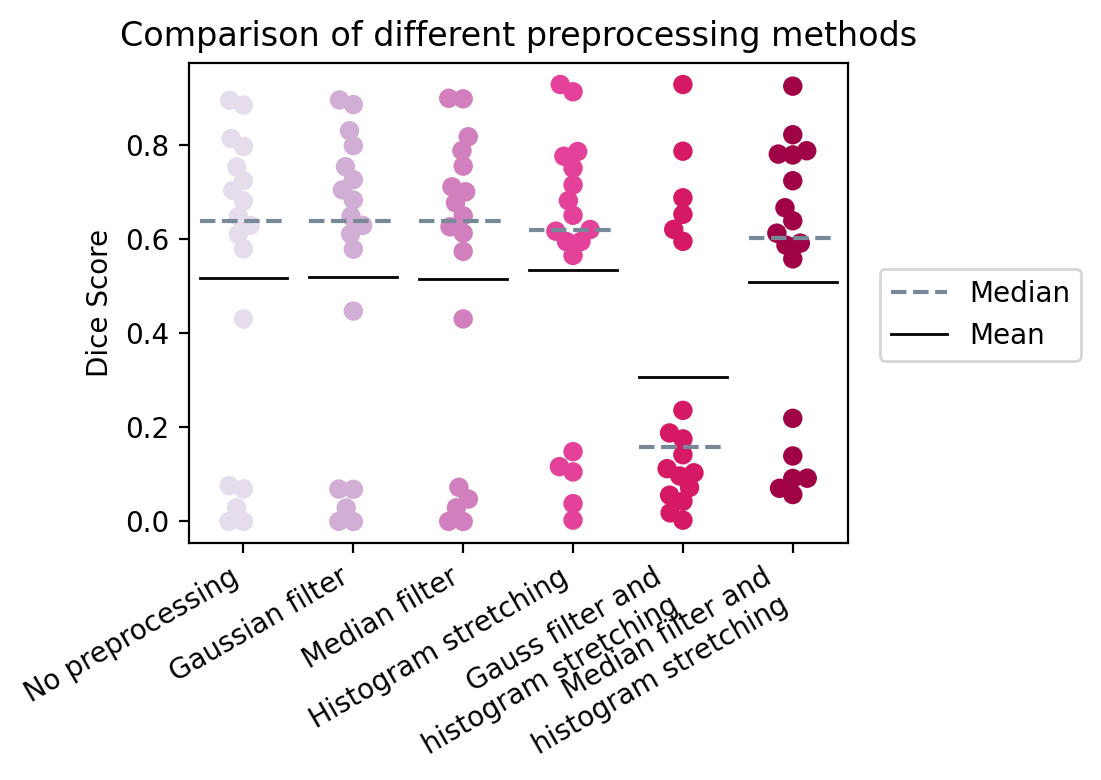

In [62]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "NIH3T3"))

The preprocessing strategy that resulted in the highest mean Dice Score (0.533) is histogram stretching.

Dice Scores with use of the two-level Otsu thresholding had a relatively big variance. The best Dice Score (0.577) resulted by images that were preprocessed using median filter as shown in the following figure.

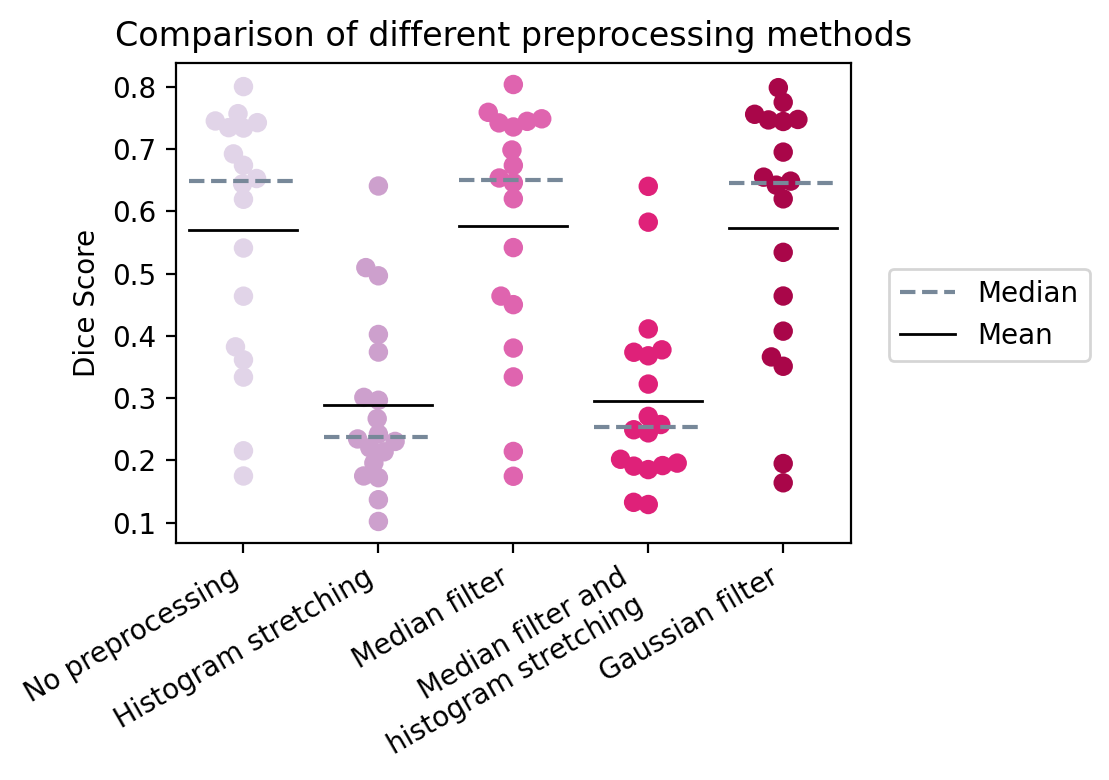

In [63]:
scores = complete_analysis.get_all_two_level_results(str(pl.Path("Results/two_lvl.json")), "NIH3T3")
visualisation.comparison_swarmplot(scores,
                                 x_label=["No preprocessing", "Histogram stretching","Median filter",
                                          "Median filter and\nhistogram stretching", "Gaussian filter"])

In both cases of one- and two-level Otsu thresholding the mean and the median values were significantly different, which means that the distribution of the Dice Score values is not symmetrical.

<h4> 3.2 NIH3T3: Discussion </h4>
<br>
As mentioned in the results, the distribution of Dice Score values after one-level Otsu segmentation was bimodal. The reason for that is that not all images in the dataset have reflections. Those without reflections are successfully segmented when using one-level Otsu thresholding. The two-level Otsu on those images on the other side is not needed and sometimes contra-productive, which results in the high variance of the results.

The following image shows results of the segmentation on an image with a few really bright reflections. Because of the intensity values in the reflection regions are much higher than the average image intensity, the one-level Otsu algorithm set the threshold value too high. Therefore most of the cell nuclei were not detected in the segmentation.

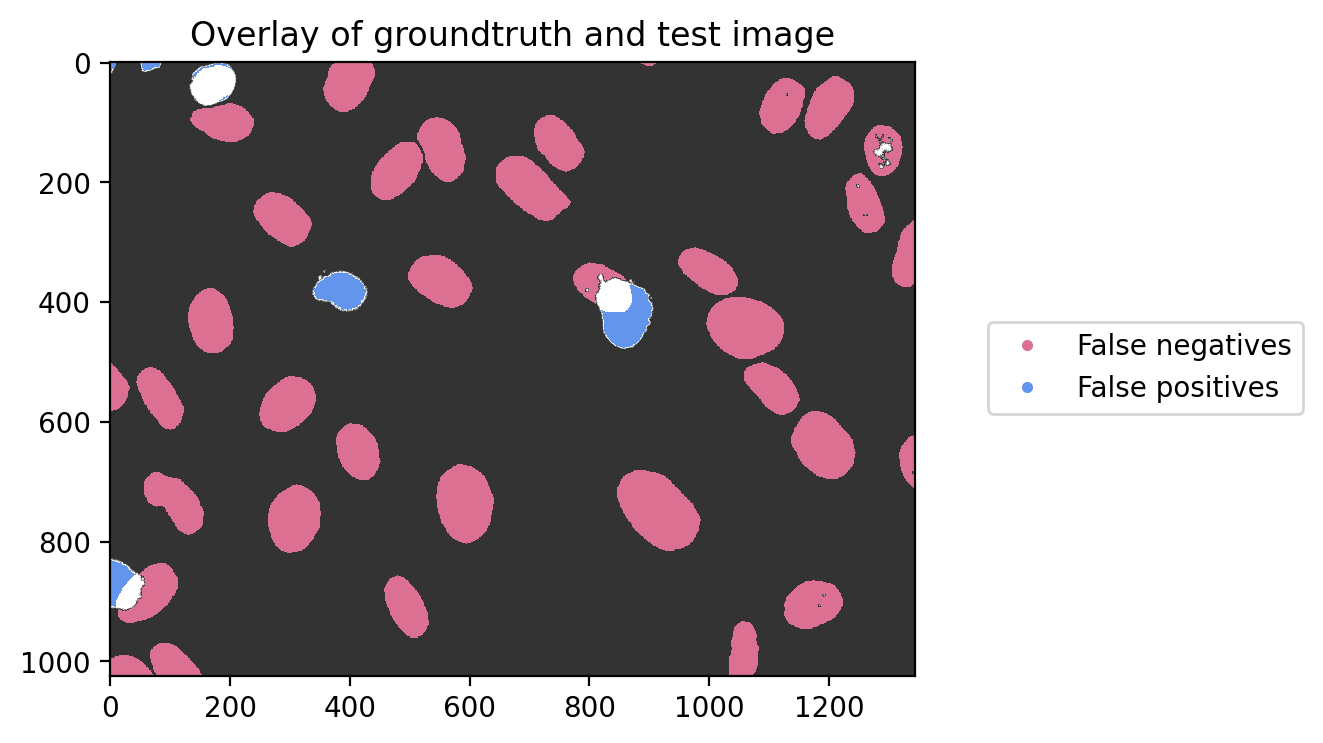

In [64]:
segmentation_one_level = otsu.complete_segmentation(io.imread(str(pl.Path('Data/NIH3T3/img/dna-47.png'))))
ground_truth = io.imread(str(pl.Path('Data/NIH3T3/gt/47.png')))
visualisation.overlay(segmentation_one_level,ground_truth)

In [65]:
#Histogram?

The same image segmented with two-level Otsu showed to be much more succesful as depicted in the image below. The values above the higher threshold were assigned to background and the values between the two thresholds were assigned to the cell nuclei

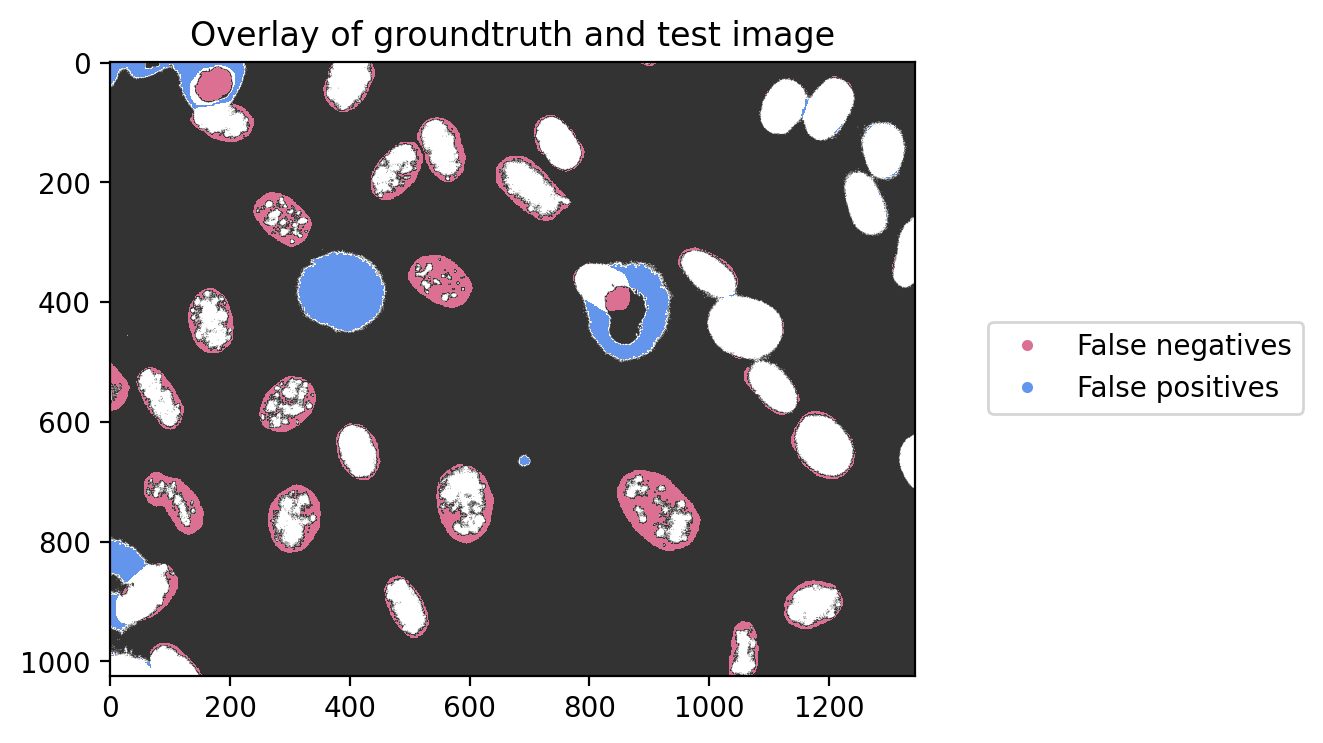

In [66]:
segmentation_two_level = otsu.complete_segmentation_twolevel(io.imread(str(pl.Path('Data/NIH3T3/img/dna-47.png'))))
visualisation.overlay(segmentation_two_level,ground_truth)

## Cell nuclei counting

### Results

The cell nuclei counting algorithm was tested on the ground truth images from N2DH-GOWT1 and N2DL-HeLa datasets. The single cell nuclei in the ground truth images in these datasets have different intensities. Therefore it is possible to extract the ground truth number of cell nuclei from the images.

The results are presented in the following tables.

In [67]:
with open(str(pl.Path('Results/cell_counting_results.json')), "r") as file:
    cell_counting_results = json.load(file)
    
table_GOWT1 = pd.DataFrame.from_dict(cell_counting_results["N2DH-GOWT1"])
table_GOWT1 = table_GOWT1.set_axis(["man_seg01.tif", "man_seg21.tif", "man_seg31.tif", 
                                    "man_seg39.tif", "man_seg52.tif", "man_seg72.tif"], axis = 0)
table_GOWT1.style.set_caption('Table 1: Results of the cell counting on the N2DH-GOWT1 dataset.')

,Calculated number,Ground truth number,Absolute difference,Relative difference
man_seg01.tif,24,23,1,0.043478
man_seg21.tif,23,24,-1,-0.041667
man_seg31.tif,24,22,2,0.090909
man_seg39.tif,23,25,-2,-0.080000
man_seg52.tif,30,30,0,0.000000
man_seg72.tif,28,28,0,0.000000


In [68]:
table_HeLa = pd.DataFrame.from_dict(cell_counting_results["N2DL-HeLa"])
table_HeLa = table_HeLa.set_axis(["man_seg13.tif", "man_seg52.tif", "man_seg75.tif", "man_seg79.tif"], axis = 0)
table_HeLa.style.set_caption('Table 2: Results of the cell counting on the N2DL-HeLa dataset.')

,Calculated number,Ground truth number,Absolute difference,Relative difference
man_seg13.tif,58,59,-1,-0.016949
man_seg52.tif,107,109,-2,-0.018349
man_seg75.tif,365,349,16,0.045845
man_seg79.tif,329,342,-13,-0.038012


In [69]:
mean_error = np.abs(np.mean(cell_counting_results["N2DL-HeLa"]["Relative difference"] 
                            + cell_counting_results["N2DH-GOWT1"]["Relative difference"]))
standard_deviation =np.abs(np.std(cell_counting_results["N2DL-HeLa"]["Relative difference"] 
                                  + cell_counting_results["N2DH-GOWT1"]["Relative difference"]))
print("Relative error (datasets combined): {} +/- {}".format(mean_error, standard_deviation))

Relative error (datasets combined): 0.001474351498372345 +/- 0.04737068686901992


### Discussion

Our algorithm could correctly calculate the cell nuclei number in only 2 of 10 images. The relative error did not exceed 10% and 5% when applied to the N2DH-GOWT1 and on the N2DL-HeLa datasets respectivly. By analyzing the images we determined the possible causes of the errors. Characteristic examples are shown below.

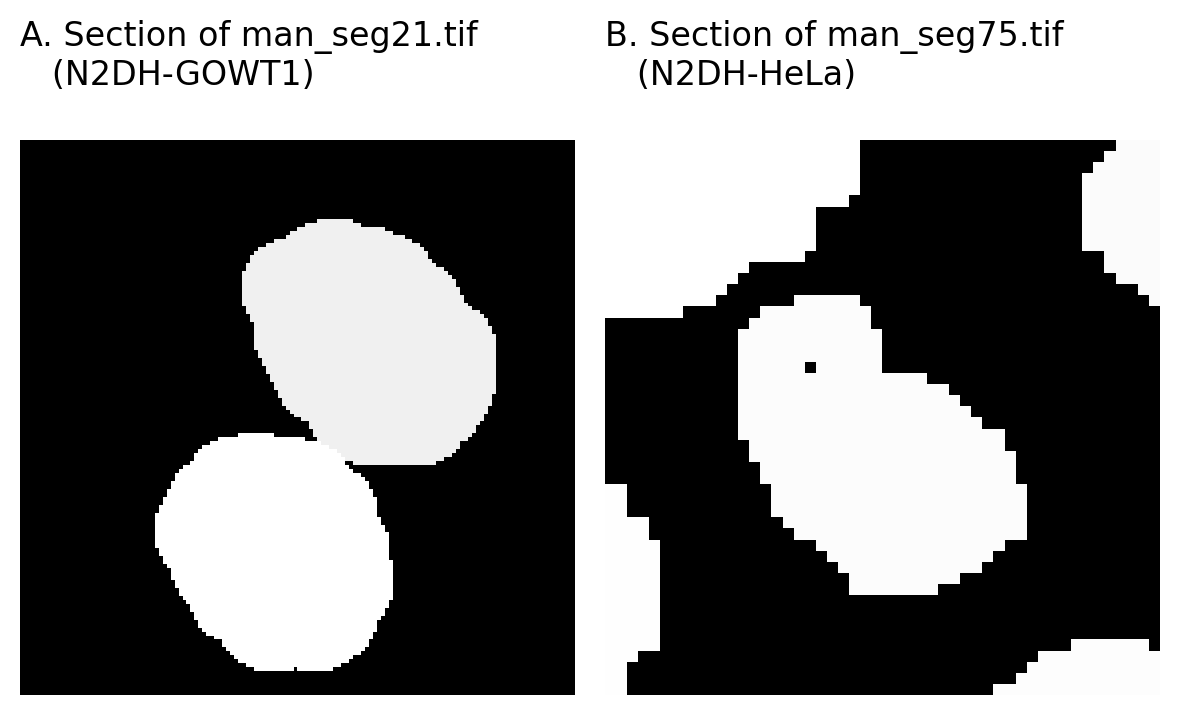

In [70]:
img_GOWT1 = io.imread(str(pl.Path('Data/N2DH-GOWT1/gt/man_seg21.tif')))
img_HeLa = io.imread(str(pl.Path('Data/N2DL-HeLa/gt/man_seg75.tif')))

visualisation.two_img_plot(img_GOWT1[660:800, 800:940], img_HeLa[610:660, 1020:1070], 
                           "A. Section of man_seg21.tif\n   (N2DH-GOWT1)", 
                           "B. Section of man_seg75.tif\n   (N2DH-HeLa)")

Some images contain touching cell nuclei as shown in the figure A. The two cell nuclei have a common border in this case, therefore our algorithm detects only one cell.

In other cases there are small black regions inside the cell nuclei, as shown in the following figure B. In this case our algorithm would detect not only the border around the cell, but also the border around the black pixel inside the cell. Since these two borders do not touch, they would be assigned to two different groups and therefore counted as two cell nuclei.

<h2>Conclusion</h2>

For both, the N2DH-GOWT1 cells and the N2DL-HeLa cells, histogram stretching was the best choice out of the
preprocessing methods we applied to the image. This is because histogram stretching enhances the contrast in the images
and makes it easier for Otsu's algorithm to select a threshold that detects cell nuclei as foreground and distinguishes
them from the background.

Also, as a preprocessing method to reduce the noise in our images, we applied two different filters. The median filter
did work better than the gaussian filter, because there is more salt-and-pepper noise in the cell
nuclei images than there is gaussian noise.

For the NIH3T3 dataset, as shown above, there is a clear advantage in using two-level Otsu in images with light spots
to exclude those light spots from the segmentation. The advantage is only given in images with the such light spots, in
other images it can distort the result.

The correctness of the threshold that Otsu's algorithm selects as well as the usefulness of the preprocessing of the
images was evaluated with two different measures, the dice score (DSC) and the mean surface distance (MSD).
The values of the DSC and the MSD differ greatly as both values explain how well
the segmentation was performed in two different kind of ways. The DSC focuses on the overlap of the ground truth and the
segmented image. The larger the area of overlap is, the higher the DSC will be.
However, the MSD calculates the distance between the edges of the cells. The greater the distance,
the greater the MSD, which implies that the segmentation is performed well. Vice versa, the smaller the MSD,
the better the segmentation.

Hausdorff has also been implied to evaluate the results, but this method is not suitable since our segmentation methods
are too imprecise and we therefore always receive very random values which are sometimes very high. Hausdorff takes the
maximum surface-distance and it is therefore logical that the values turn out to be very high. However, we are of the
opinion that Hausdorff is not really of use to us which is the reason why we did not applying this evaluation method.

After segmenting the images, a cell counting algorithm can be applied. We tried this for the N2DH-GOWT1 and the N2DL-HeLa
cell nuclei datasets and it worked quite well with a maximum deviation of ten percent.


<h2>Literature</h2>

Ba´rtova´ E, Sˇusta´cˇkova´ G, Stixova´ L, Kozubek S, Legartova´ S, et al. (2011) Recruitment of Oct4 Protein to UV-Damaged Chromatin in Embryonic Stem
Cells. PLoS ONE 6(12): e27281. doi:10.1371/journal.pone.0027281

Neumann B, Walter T, Hériché JK, Bulkescher J, Erfle H, Conrad C, Rogers P, Poser I, Held M, Liebel U, Cetin C,
Sieckmann F, Pau G, Kabbe R, Wünsche A, Satagopam V, Schmitz MH, Chapuis C, Gerlich DW, Schneider R, Eils R, Huber W, Peters JM, Hyman AA, Durbin R, Pepperkok R, Ellenberg J.
Phenotypic profiling of the human genome by time-lapse microscopy reveals cell division genes. Nature. 2010 Apr 1;464(7289):721-7. doi: 10.1038/nature08869

L. P. Coelho, A. Shariff and R. F. Murphy, "Nuclear segmentation in microscope cell images: A hand-segmented dataset and comparison of algorithms,"
2009 IEEE International Symposium on Biomedical Imaging: From Nano to Macro, 2009, pp. 518-521, doi: 10.1109/ISBI.2009.5193098.

N. Otsu, "A Threshold Selection Method from Gray-Level Histograms," in IEEE Transactions on Systems, Man, and Cybernetics, vol. 9, no. 1, pp. 62-66, Jan. 1979, doi: 10.1109/TSMC.1979.4310076.